# SDSC 5001 Project

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import *
import seaborn as sns
import os
from tqdm import tqdm
tqdm.pandas()

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, LogisticRegression, LogisticRegressionCV, LinearRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.utils import resample

import warnings 
warnings.filterwarnings('ignore')

## Read data and Data Preprocessing

Read data from `training.xlsx` and `test.xlsx`.

`training.xlsx` contains 837 labeled samples while `test.xlsx` contains 20 unlabeled samples for us to predict.

It is more proper to call the DataFrame from `test.xlsx` as `commit_df` since it is the commit dataset.

In [33]:
class_balance = False
train_path = './副本training.xlsx'
test_path = './副本test.xlsx'

train_df = pd.read_excel(train_path)
commit_df = pd.read_excel(test_path)

print('We has {} labeled samples and has {} samples to predict'.format(len(train_df), len(commit_df)))

We has 837 labeled samples and has 20 samples to predict


### Preprocessing the data

#### Preprocessing: normalization

Normalize each feature range to (0, 1).

In [34]:
scaler = MinMaxScaler()
train_df_scaled = scaler.fit_transform(train_df)
train_df_scaled_df = pd.DataFrame(train_df_scaled)
commit_X = scaler.fit_transform(commit_df.iloc[:, :-1])

#### Preprocessing:  Split the dataset into training set and test set.

In [35]:
random_state = 5813
train_ratio = 0.8
test_ratio = 0.1
val_ratio = 0.1
X = train_df_scaled[:, :-1]
y = train_df_scaled[:, -1]
n_features = X.shape[1]

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=test_ratio, random_state=random_state)
train_pos_ratio = np.sum(train_y) / len(train_y)
test_pos_ratio = np.sum(test_y) / len(test_y)
print('Train set size: {}, train_pos_ratio: {:.3f}, test set size: {}, test_pos_ratio: {:.3f}'.format(len(train_X), train_pos_ratio, len(test_X), test_pos_ratio))
# train_vX, val_X, train_vy, val_y = train_test_split(train_X, train_y, test_size=val_ratio/(val_ratio+train_ratio), random_state=random_state)
# print('train_vX set size: {}, test set size: {}, validation set size: {}'.format(len(train_vX), len(test_X), len(val_X)))

Train set size: 753, train_pos_ratio: 0.198, test set size: 84, test_pos_ratio: 0.190


#### Preprocessing: Class Balance(optional)

In [5]:
resampling_ratio = 1.0

train_X_df = pd.DataFrame(train_X)
train_y_df = pd.DataFrame(train_y, columns=['Y'])
train_df = pd.concat([train_X_df, train_y_df], axis=1)

class_balance = True

train_df_1 = train_df[train_df.Y == 1]
train_df_0 = train_df[train_df.Y == 0]

print('Before resampling, train_df has {} $1$ instances and {} $0$ instances, the ratio is: {:.4f}.'.format(len(train_df_1), len(train_df_0), len(train_df_1)/len(train_df_0)))

train_df_1_upsampled = resample(train_df_1, replace=True,
                                n_samples=int(len(train_df_0) * resampling_ratio),
                                random_state=random_state)

train_df = pd.concat([train_df_1_upsampled, train_df_0]).reset_index(drop=True)
train_df_1 = train_df[train_df.Y == 1]
train_df_0 = train_df[train_df.Y == 0]
print('After resampling, train_df has {} $1$ instances and {} $0$ instances, the ratio is: {:.4f}.'.format(len(train_df_1), len(train_df_0), len(train_df_1)/len(train_df_0)))

train_X = train_df.iloc[:, :-1]
train_y = train_df.iloc[:, -1]

train_pos_ratio = np.sum(train_y) / len(train_y)
test_pos_ratio = np.sum(test_y) / len(test_y)
print('Train set size: {}, train_pos_ratio: {:.3f}, test set size: {}, test_pos_ratio: {:.3f}'.format(len(train_X), train_pos_ratio, len(test_X), test_pos_ratio))

Before resampling, train_df has 149 $1$ instances and 604 $0$ instances, the ratio is: 0.2467.
After resampling, train_df has 604 $1$ instances and 604 $0$ instances, the ratio is: 1.0000.
Train set size: 1208, train_pos_ratio: 0.500, test set size: 84, test_pos_ratio: 0.190


## EDA

Basic statistics on the datasets.

In [6]:
train_df.describe()

X1          X2          X3          X4          X5          X6  \
count  837.000000  837.000000  837.000000  837.000000  837.000000  837.000000   
mean     7.020072    0.362670    0.304743    4.970968    0.056883   30.143369   
std      1.026050    0.175893    0.153008    4.647922    0.034279   17.416437   
min      4.800000    0.080000    0.000000    0.800000    0.017000    3.000000   
25%      6.300000    0.240000    0.220000    1.700000    0.040000   16.000000   
50%      6.900000    0.310000    0.320000    2.300000    0.048000   28.000000   
75%      7.500000    0.450000    0.400000    7.500000    0.066000   41.000000   
max     12.600000    1.040000    1.000000   22.000000    0.414000  131.000000   

               X7          X8          X9         X10         X11         X12  \
count  837.000000  837.000000  837.000000  837.000000  837.000000  837.000000   
mean   113.126643    0.994739    3.257515    0.546989   10.341935    1.692951   
std     62.110823    0.002478    0.166537    0.143388    1.059695    0.461546   
min      8.000000    0.988600    2.870000    0.270000    8.500000    1.000000   
25%     60.000000    0.992800    3.140000    0.440000    9.500000    1.000000   
50%    114.000000    0.994800    3.250000    0.530000   10.200000    2.000000   
75%    159.000000    0.996590    3.370000    0.620000   11.000000    2.000000   
max    313.000000    1.003690    4.010000    1.330000   14.000000    2.000000   

                Y  
count  837.000000  
mean     0.197133  
std      0.398071  
min      0.000000  
25%      0.000000  
50%      0.000000  
75%      0.000000  
max      1.000000

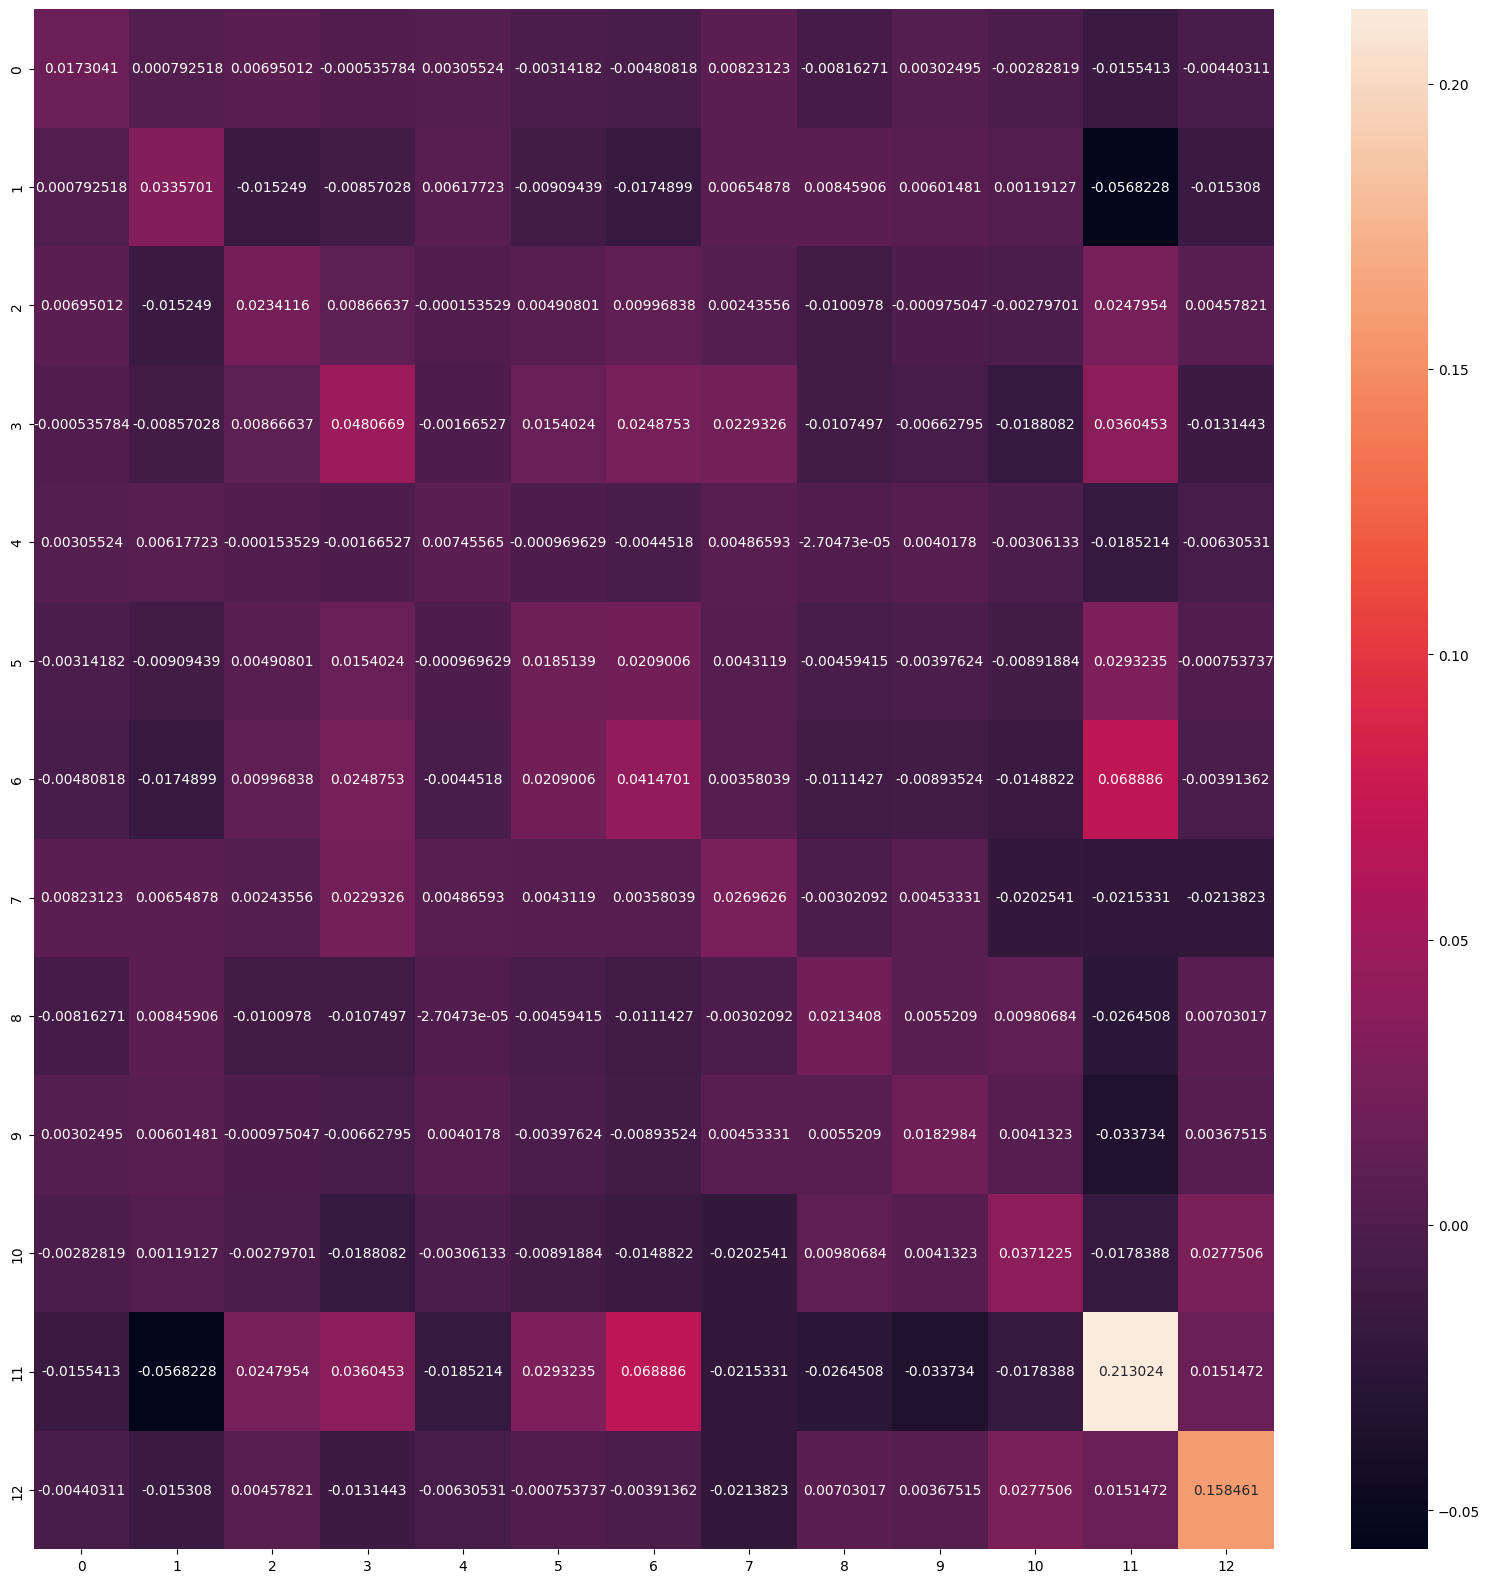

In [7]:
plt.figure(figsize=(20, 20))
cov_matrix = pd.DataFrame.cov(train_df_scaled_df)
sns.heatmap(cov_matrix, annot=True, fmt='g')
plt.show()

#### Pair Plot

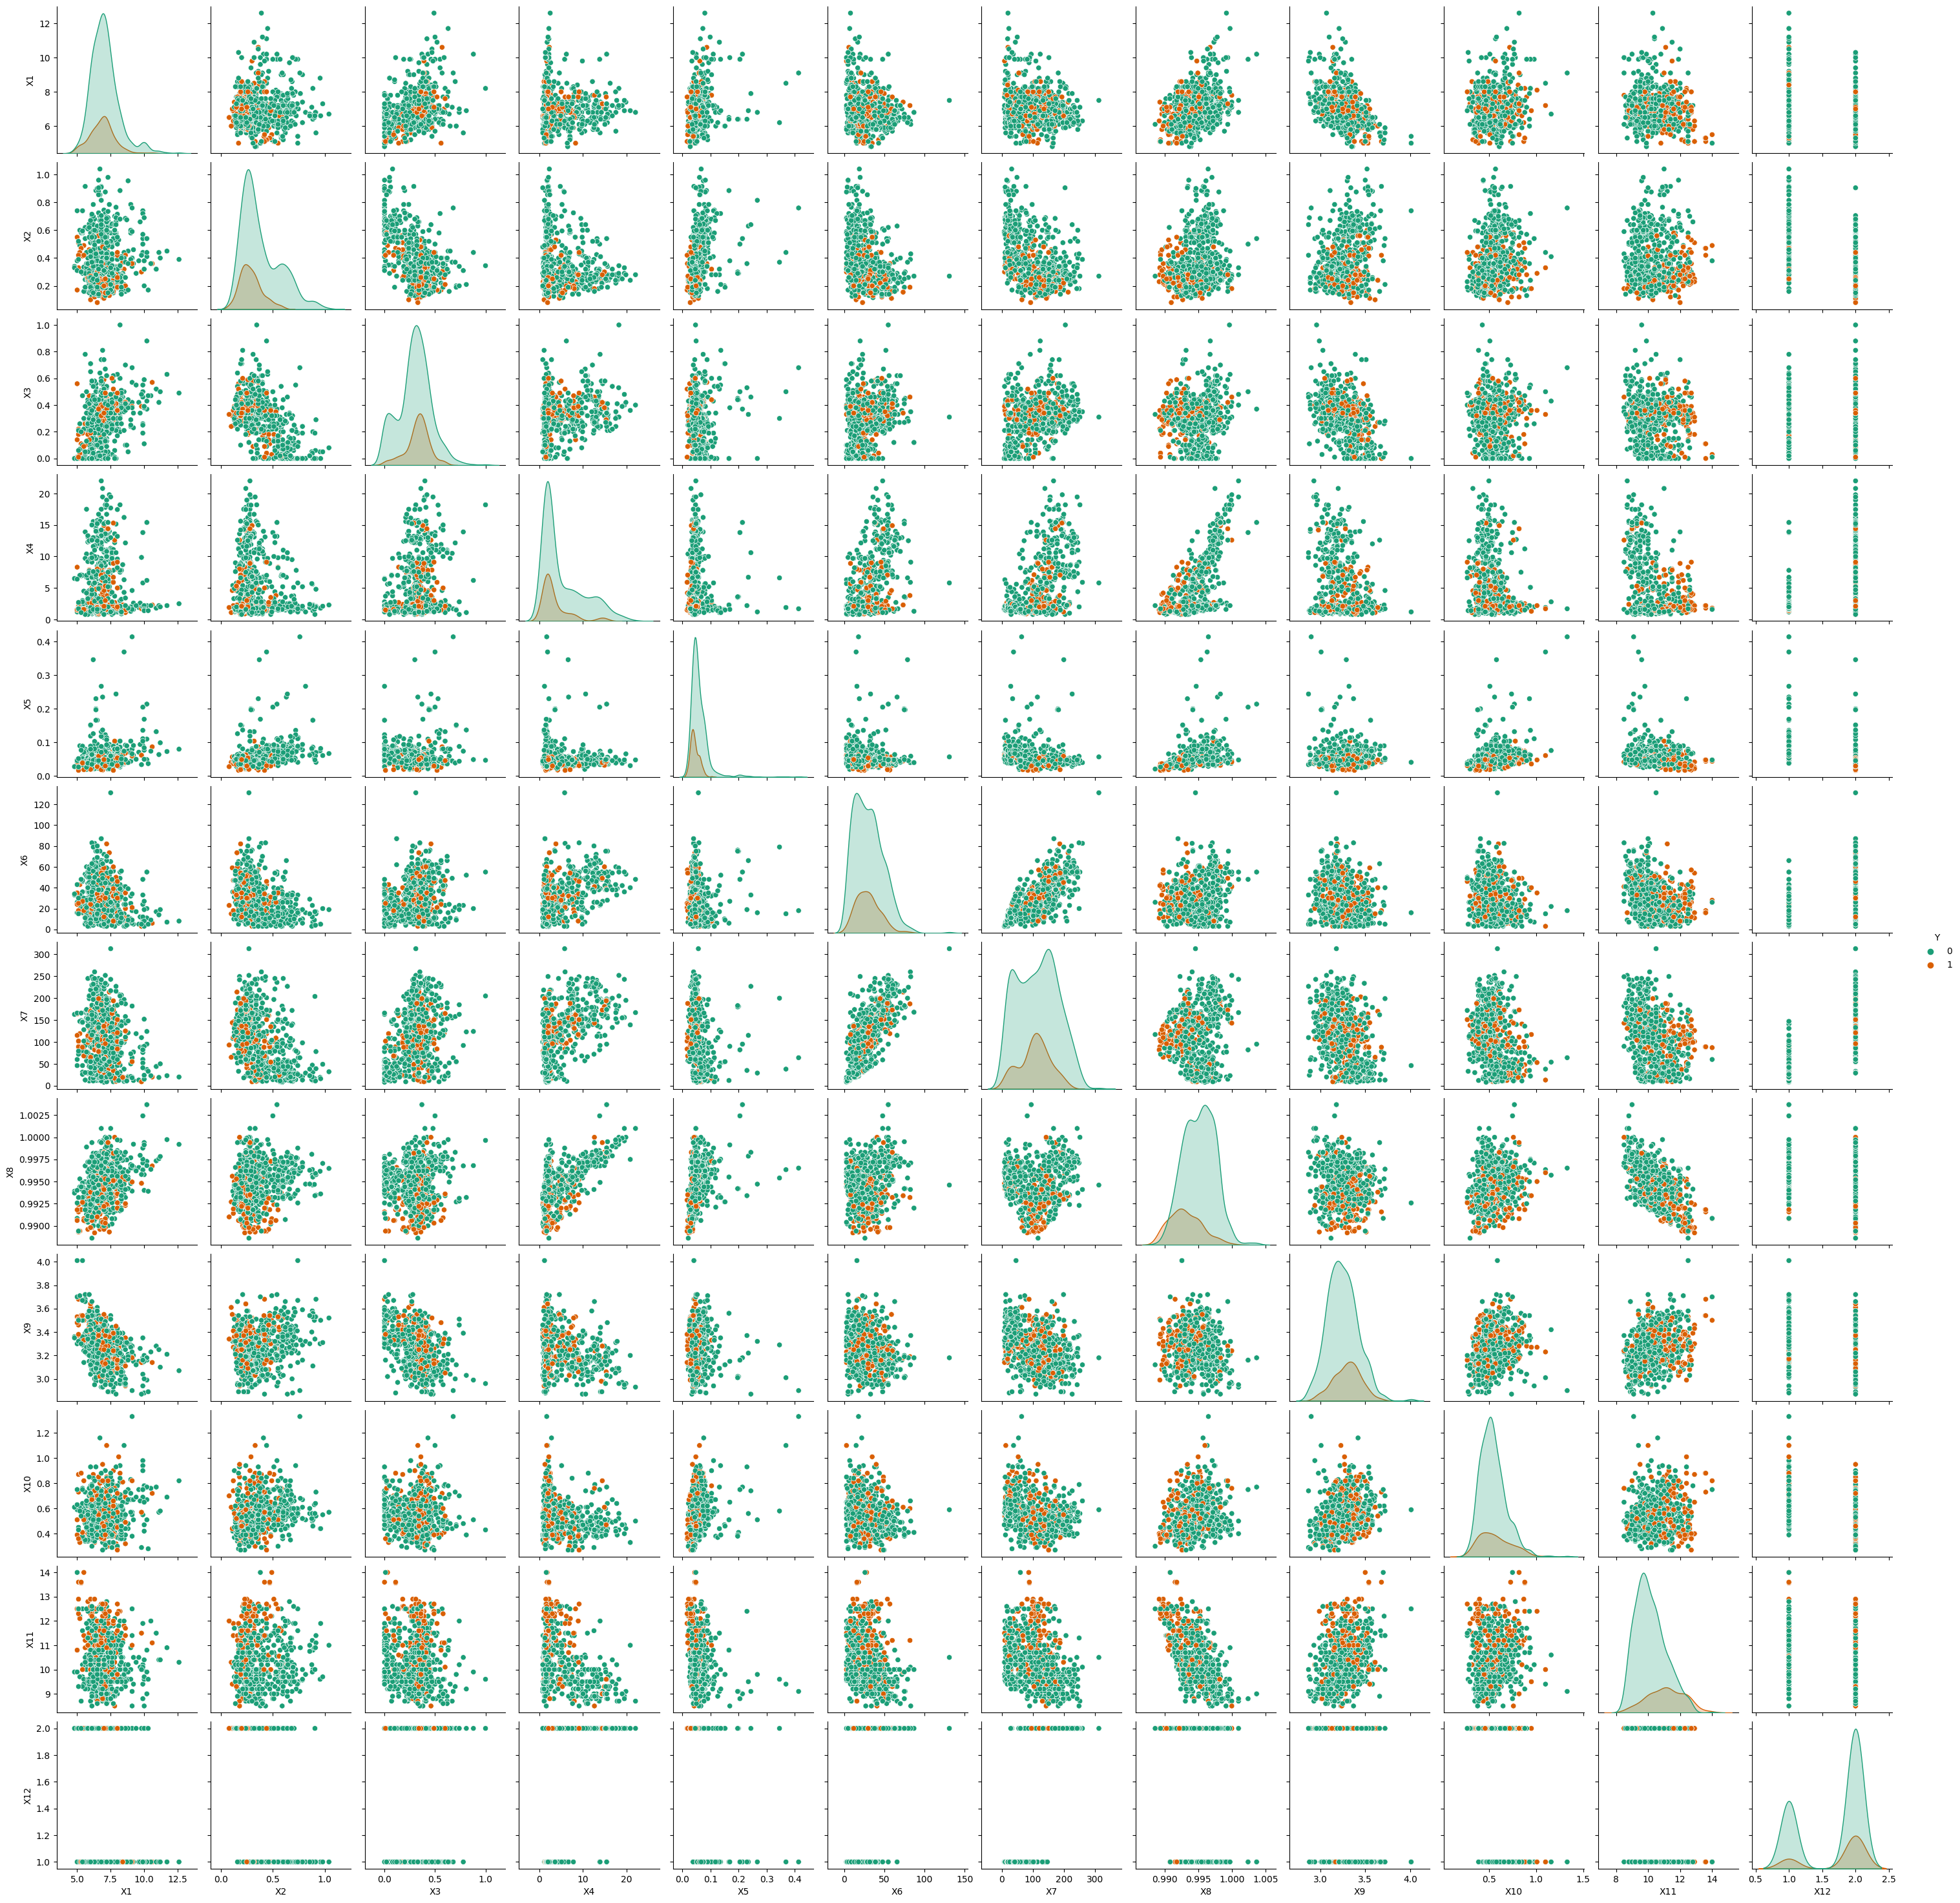

In [57]:
sns.pairplot(train_df, hue='Y', palette='Dark2')
plt.show()

## Modeling

Define a DataFrame to record the performance of different models.

In [58]:
performance_df = pd.DataFrame(columns=['model', 'accuracy', 'precision',
                                       'recall', 'f1', 'roc_auc'])

Define tool functions to evaluate models and record performance

In [59]:
def eval_model(model, train_X=train_X, train_y=train_y, test_X=test_X, test_y=test_y):
    model.fit(train_X, train_y)
    y_pred_train = model.predict(train_X)
    y_pred = model.predict(test_X)
    train_acc = model.score(train_X, train_y)
    test_acc = model.score(test_X, test_y)
    return train_acc, test_acc

def model_performance(model, modelname=None, testx=test_X, testy=test_y):
    y_pred = model.predict(testx)
    acc = accuracy_score(y_pred, testy)
    prec = precision_score(y_pred, testy)
    recall = recall_score(y_pred, testy)
    f1 = f1_score(y_pred, testy)
    roc_auc = roc_auc_score(y_pred, testy)
    if modelname is None:
        modelname = model.__class__.__name__
    return {'model': modelname, 'accuracy': acc, 'precision': prec, 
            'recall': recall, 'f1': f1, 'roc_auc': roc_auc}

def performance_measure(model, modelname_suffix=None, modelname=None, class_balance=class_balance, train_X=train_X, train_y=train_y,test_X=test_X, test_y=test_y):
    train_acc, test_acc = eval_model(model, train_X=train_X, train_y=train_y, test_X=test_X, test_y=test_y)
    print('train_acc: {:.4f}, test_acc: {:.4f}'.format(train_acc, test_acc))
    
    if modelname is None:
        if class_balance:
            modelname = str(model.__class__.__name__) + '_balanced'
        else:
            modelname = str(model.__class__.__name__)
            
    if modelname_suffix is not None:
        modelname = modelname + modelname_suffix
        
    performance_dict = model_performance(model, modelname=modelname, testx=test_X, testy=test_y)
    return performance_dict

### Dimension Reducing

#### PCA

In [36]:
n_components_list = np.arange(1, n_features + 1)
train_X_pca_dict = {}
test_X_pca_dict = {}
for n_components in n_components_list:
    pca_reducer = PCA(n_components=n_components)
    train_X_pca_dict[n_components] = pca_reducer.fit_transform(train_X)
    test_X_pca_dict[n_components] = pca_reducer.fit_transform(test_X)

#### SVD

In [37]:
train_X_svd_dict = {}
test_X_svd_dict = {}
for n_component in n_components_list:
    svd_reducer = TruncatedSVD(random_state=0, n_components=n_component)
    train_X_svd_dict[n_components] = svd_reducer.fit_transform(train_X)
    test_X_svd_dict[n_components] = svd_reducer.fit_transform(test_X)

#### TSNE-2D

In [38]:
train_X_tsne_2_dict = {}
test_X_tsne_2_dict = {}
tsne_2_reducer = TSNE(n_components=2, random_state=0)
train_X_tsne_2_dict = tsne_2_reducer.fit_transform(train_X)
test_X_tsne_2_dict= tsne_2_reducer.fit_transform(test_X)

#### TSNE-3D

In [12]:
train_X_tsne_3_dict = {}
test_X_tsne_3_dict = {}
tsne_3_reducer = TSNE(n_components=3, random_state=0)
train_X_tsne_3_dict = tsne_3_reducer.fit_transform(train_X)
test_X_tsne_3_dict = tsne_3_reducer.fit_transform(test_X)

### Plain Logistic Regression

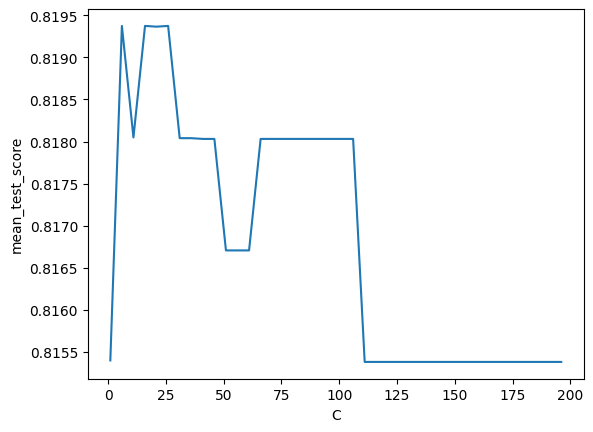

In [53]:
param_grid = {'C':np.arange(1. ,200., 5.)}
logistic_model = LogisticRegression(max_iter=2000)
clf = GridSearchCV(logistic_model, param_grid)
clf.fit(train_X, train_y)
clf.cv_results_.keys()
plt.plot(np.ma.getdata(clf.cv_results_['param_C']), np.ma.getdata(clf.cv_results_['mean_test_score']))
plt.xlabel('C')
plt.ylabel('mean_test_score')
plt.show()
# performance_dict = performance_measure(logistic_model, modelname_suffix='(C=0.4)')
# performance_df = performance_df.append(performance_dict, ignore_index=True)

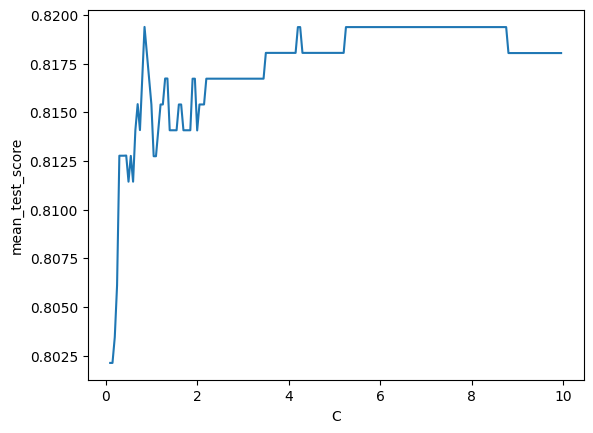

In [50]:
param_grid = {'C':np.arange(0.1 ,10., 0.05)}
logistic_model = LogisticRegression(max_iter=2000)
clf = GridSearchCV(logistic_model, param_grid)
clf.fit(train_X, train_y)
clf.cv_results_.keys()
plt.plot(np.ma.getdata(clf.cv_results_['param_C']), np.ma.getdata(clf.cv_results_['mean_test_score']))
plt.xlabel('C')
plt.ylabel('mean_test_score')
plt.show()
# performance_dict = performance_measure(logistic_model, modelname_suffix='(C=0.4)')
# performance_df = performance_df.append(performance_dict, ignore_index=True)

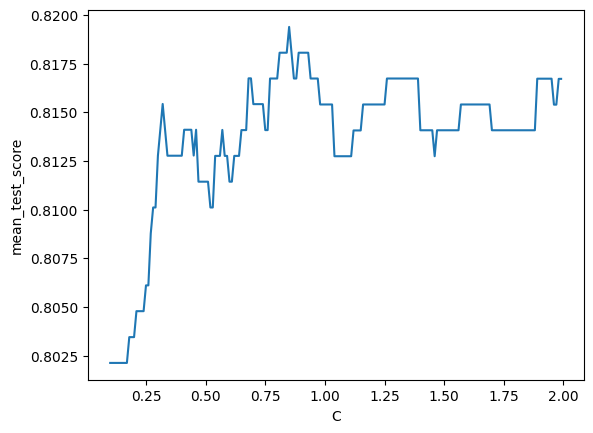

In [52]:
param_grid = {'C':np.arange(0.1 ,2., 0.01)}
logistic_model = LogisticRegression(max_iter=2000)
clf = GridSearchCV(logistic_model, param_grid)
clf.fit(train_X, train_y)
clf.cv_results_.keys()
plt.plot(np.ma.getdata(clf.cv_results_['param_C']), np.ma.getdata(clf.cv_results_['mean_test_score']))
plt.xlabel('C')
plt.ylabel('mean_test_score')
plt.show()
# performance_dict = performance_measure(logistic_model, modelname_suffix='(C=0.4)')
# performance_df = performance_df.append(performance_dict, ignore_index=True)

The best C value is: 0.82

### Decision Tree

### Random Forest

In [63]:
criterions = ['gini', 'entropy', 'log_loss']
max_depths = 3 + np.arange(15)

param_grid = {
    'criterion':['gini', 'entropy', 'log_loss'],
    'max_depth': np.arange(3, 18),
    'n_estimators' : [10, 20, 50, 100, 200, 300]
}

rf_model = RandomForestClassifier()

clf = GridSearchCV(rf_model, param_grid)
clf.fit(train_X, train_y)
clf.cv_results_.keys()
y_pred = clf.predict(test_X)
accuracy_score(y_pred, test_y)

0.8690476190476191

### SVM

Not yet tuning the hyperparameters

In [65]:
gamma = 17.5
svm = SVC(kernel='rbf', gamma =17.5)

model_suf = '_{}_{}_'.format('rbf', gamma)
performance_dict = performance_measure(rf_model, modelname_suffix=model_suf)
performance_df = performance_df.append(performance_dict, ignore_index=True)

train_acc: 1.0000, test_acc: 0.8810


In [66]:
performance_df

model  accuracy  precision  recall        f1  \
0  RandomForestClassifier_rbf_17.5_  0.880952     0.5625    0.75  0.642857   

    roc_auc  
0  0.826389

### KMeans

In [39]:
# due to TSNE can only reduce the dims into two or three, so here we deliberately seperate it into 2-dim and 3-dim

def plot_embedding_2d(X, y, title=None):
    """Plot an embedding X with the class label y colored by the domain d."""
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    # Plot colors numbers
    plt.figure(figsize=(3,3))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        # plot colored number
        plt.text(X[i, 0], X[i, 1],str(y[i]),
                 color=plt.cm.Set1(y[i]),
                 fontdict={"weight": 'bold', 'size': 9})

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
    plt.show()

def plot_embedding_3d(X,y, title=None):
  
    x_min, x_max = np.min(X,axis=0), np.max(X,axis=0)
    X = (X - x_min) / (x_max - x_min)
    
    fig = plt.figure(figsize=(3,3))
    #ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax = Axes3D(fig)
    for i in range(X.shape[0]):
        ax.text(X[i, 0], X[i, 1], X[i,2],str(y),
                 color=plt.cm.Set3(y[i]),
                 fontdict={'weight': 'bold', 'size': 9})
    if title is not None:
        plt.title(title)
    plt.show()
        



KMeans, init=k-means++, PCA_n_comps:2, test acc: 0.6309523809523809, precision_score:0.25, recall_score:0.17391304347826086, f1_score:0.20512820512820512, roc_auc_score:0.48859586600142546
KMeans, init=k-means++, PCA_n_comps:3, test acc: 0.36904761904761907, precision_score:0.75, recall_score:0.19672131147540983, f1_score:0.3116883116883117, roc_auc_score:0.5114041339985745
KMeans, init=k-means++, PCA_n_comps:4, test acc: 0.6309523809523809, precision_score:0.25, recall_score:0.17391304347826086, f1_score:0.20512820512820512, roc_auc_score:0.48859586600142546
KMeans, init=k-means++, PCA_n_comps:5, test acc: 0.36904761904761907, precision_score:0.75, recall_score:0.19672131147540983, f1_score:0.3116883116883117, roc_auc_score:0.5114041339985745
KMeans, init=k-means++, PCA_n_comps:6, test acc: 0.36904761904761907, precision_score:0.75, recall_score:0.19672131147540983, f1_score:0.3116883116883117, roc_auc_score:0.5114041339985745
KMeans, init=k-means++, PCA_n_comps:7, test acc: 0.6309523

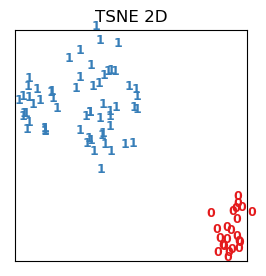

In [ ]:
from sklearn.cluster import KMeans


inits = ['k-means++', 'random']
n_components = np.arange(2, 13)
# low_ds=["PCA","SVD"]
low_ds=["PCA","SVD"]

for init in inits:
    for low_d in low_ds:
        # PCA and SVD can reduce dim into any dimentions, so we put them together
        for n_component in n_components:
            if low_d=="PCA":
                reducer = PCA(n_components=n_component)
                train_X_pca = reducer.fit_transform(train_X)
                test_X_pca = reducer.fit_transform(test_X)
                kmeans_model = KMeans(n_clusters=2, init=init, max_iter=1000)
                y_pred = kmeans_model.fit_predict(test_X)
                print('KMeans, init={}, PCA_n_comps:{}, test acc: {}, precision_score:{}, recall_score:{}, f1_score:{}, roc_auc_score:{}'.format(init, n_component, accuracy_score(y_pred, test_y),precision_score(y_pred, test_y), recall_score(y_pred, test_y), f1_score(y_pred, test_y), roc_auc_score(y_pred, test_y)))
            else:
                reducer_1 = TruncatedSVD(random_state=0, n_components=n_component)
                train_X_svd = reducer_1.fit_transform(train_X)
                test_X_svd = reducer_1.fit_transform(test_X)
                kmeans_model = KMeans(n_clusters=2, init=init, max_iter=1000)
                y_pred = kmeans_model.fit_predict(test_X)
                print('KMeans, init={}, SVD_n_comps:{}, test acc: {}, precision_score:{}, recall_score:{}, f1_score:{}, roc_auc_score:{}'.format(init, n_component, accuracy_score(y_pred, test_y),precision_score(y_pred, test_y), recall_score(y_pred, test_y), f1_score(y_pred, test_y), roc_auc_score(y_pred, test_y)))
        

    for n_component in range(2,4):        
        reducer = TSNE(n_components=n_component, random_state=0)
        train_X_tsne = reducer.fit_transform(train_X)
        test_X_tsne = reducer.fit_transform(test_X)
        kmeans_model = KMeans(n_clusters=2, init=init, max_iter=1000)
        y_pred = kmeans_model.fit_predict(test_X)
        if n_component==2:
            print('KMeans, init={}, TSNE_2_n_comps:{}, test acc: {}, precision_score:{}, recall_score:{}, f1_score:{}, roc_auc_score:{}'.format(init, n_component, accuracy_score(y_pred, test_y),precision_score(y_pred, test_y), recall_score(y_pred, test_y), f1_score(y_pred, test_y), roc_auc_score(y_pred, test_y)))
            plot_embedding_2d(test_X_tsne[:,0:2],y_pred,"TSNE 2D")
        else:
            print('KMeans, init={}, TSNE_3_n_comps:{}, test acc: {}'.format(init, n_component, accuracy_score(y_pred, test_y)))
            plot_embedding_3d(test_X_tsne[:,0:3],y,"TSNE 3D")

In [68]:
print(np.argmax(performance_df.accuracy))
print(np.max(performance_df.accuracy))

# use the model with highest accuracy to predict 

0
0.8809523809523809


## Neural Network

In [69]:
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam

model = Sequential()
model.add(Dense(64, activation='relu', input_dim=12))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
opt = Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics='accuracy')

In [70]:
hist = model.fit(train_X, train_y, epochs=100, batch_size=10, validation_split=0.1)

Epoch 1/100
68/68 [==============================] - 2s 5ms/step - loss: 0.5072 - accuracy: 0.7888 - val_loss: 0.4287 - val_accuracy: 0.8158
Epoch 2/100
68/68 [==============================] - 0s 3ms/step - loss: 0.4361 - accuracy: 0.8006 - val_loss: 0.3963 - val_accuracy: 0.8158
Epoch 3/100
68/68 [==============================] - 0s 3ms/step - loss: 0.4081 - accuracy: 0.8095 - val_loss: 0.3841 - val_accuracy: 0.8421
Epoch 4/100
68/68 [==============================] - 0s 3ms/step - loss: 0.3899 - accuracy: 0.8139 - val_loss: 0.3796 - val_accuracy: 0.8421
Epoch 5/100
68/68 [==============================] - 0s 3ms/step - loss: 0.3860 - accuracy: 0.8213 - val_loss: 0.3760 - val_accuracy: 0.8684
Epoch 6/100
68/68 [==============================] - 0s 3ms/step - loss: 0.3773 - accuracy: 0.8168 - val_loss: 0.3729 - val_accuracy: 0.8684
Epoch 7/100
68/68 [==============================] - 0s 3ms/step - loss: 0.3757 - accuracy: 0.8213 - val_loss: 0.3711 - val_accuracy: 0.8684
Epoch 8/100
6

Epoch 59/100
68/68 [==============================] - 0s 3ms/step - loss: 0.2404 - accuracy: 0.9025 - val_loss: 0.4401 - val_accuracy: 0.7895
Epoch 60/100
68/68 [==============================] - 0s 3ms/step - loss: 0.2311 - accuracy: 0.9025 - val_loss: 0.4420 - val_accuracy: 0.8026
Epoch 61/100
68/68 [==============================] - 0s 3ms/step - loss: 0.2374 - accuracy: 0.8996 - val_loss: 0.4171 - val_accuracy: 0.8289
Epoch 62/100
68/68 [==============================] - 0s 3ms/step - loss: 0.2338 - accuracy: 0.8892 - val_loss: 0.4417 - val_accuracy: 0.8158
Epoch 63/100
68/68 [==============================] - 0s 3ms/step - loss: 0.2295 - accuracy: 0.9010 - val_loss: 0.4548 - val_accuracy: 0.7763
Epoch 64/100
68/68 [==============================] - 0s 3ms/step - loss: 0.2367 - accuracy: 0.8996 - val_loss: 0.4396 - val_accuracy: 0.8158
Epoch 65/100
68/68 [==============================] - 0s 3ms/step - loss: 0.2344 - accuracy: 0.8907 - val_loss: 0.4395 - val_accuracy: 0.8421
Epoch 

In [71]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

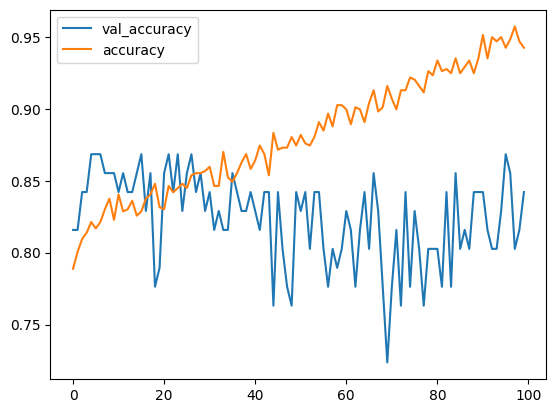

In [72]:
plt.plot(hist.history['val_accuracy'],label='val_accuracy')
plt.plot(hist.history['accuracy'],label='accuracy')
plt.legend()
plt.show()